# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [5]:
env = UnityEnvironment(file_name='/home/slavo/Dev/deep-reinforcement-learning/p2_continuous-control/Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [8]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.0


When finished, you can close the environment.

In [9]:
env.close()

### 4. PPO Agent Training

In [1]:
from collections import deque

import numpy as np
import time
import torch
from agent import PPOAgent
from config import Config
from model import Actor, Critic, ActorCritic
from torch_utils import select_device, set_one_thread, random_seed
from unityagents import UnityEnvironment

In [2]:
def ppo():
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    env = UnityEnvironment(file_name="../Reacher_Linux/Reacher.x86_64", no_graphics=True)

    # get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]

    # reset the environment
    env_info = env.reset(train_mode=True)[brain_name]

    # number of agents in the environment
    print('Number of agents:', len(env_info.agents))

    # number of actions
    action_size = brain.vector_action_space_size
    print('Number of actions:', action_size)

    # examine the state space
    state = env_info.vector_observations[0]
    print('States look like:', state)
    state_size = len(state)
    print('States have length:', state_size)

    print("GPU available: {}".format(torch.cuda.is_available()))
    print("GPU tensor test: {}".format(torch.rand(3, 3).cuda()))

    config = Config()
    config.env = env

    config.actor_critic_fn = lambda: ActorCritic(actor=Actor(state_size, action_size),
                                                 critic=Critic(state_size))

    config.discount = 0.99
    config.use_gae = True
    config.gae_tau = 0.95
    config.gradient_clip = 5
    config.rollout_length = 20 * 512
    config.optimization_epochs = 10
    config.num_mini_batches = 512
    config.ppo_ratio_clip = 0.2
    config.log_interval = 600 * 512
    config.max_steps = 2e7
    config.eval_episodes = 10

    agent = PPOAgent(config)

    random_seed()
    config = agent.config
    scores = []
    scores_window = deque(maxlen=100)  # last 100 scores
    t0 = time.time()

    while True:
        if config.log_interval and not agent.total_steps % config.log_interval and len(agent.episode_rewards):
            rewards = agent.episode_rewards
            for reward in rewards:
                scores.append(reward)
                scores_window.append(reward)
            agent.episode_rewards = []

            print('\r===> Average Score: {:d} episodes {:.2f}'.format(len(scores), np.mean(scores_window)))
            if np.mean(scores_window) >= 30.0:
                print('\nEnvironment solved in {:d}  episodes!\tAverage Score: {:.2f}'.format(len(scores_window),
                                                                                              np.mean(scores_window)))
                torch.save(agent.actor_critic.state_dict(), '../checkpoints/ppo_checkpoint.pth')
                break

            print('Total steps %d, returns %d/%.2f/%.2f/%.2f/%.2f (count/mean/median/min/max), %.2f steps/s' % (
                agent.total_steps, len(rewards), np.mean(rewards), np.median(rewards), np.min(rewards), np.max(rewards),
                config.log_interval / (time.time() - t0)))

            t0 = time.time()

        agent.step()
    
    return scores

In [3]:
set_one_thread()
select_device(0)
scores = ppo()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Number of agents: 1
Number of actions: 4
States look like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]
States have length: 33
GPU available: True
GPU tensor test: tensor([[0.4451, 0.9547, 0.1725],
        [0.9806, 0.8925, 0.9935],
        [0.5442, 0.0992, 0.2953]], device='cuda:0')
===> Average Score: 306 episodes 1.43
Total steps 307200, returns 306/0.89/0.81/0.00/3.80 (count/mean/median/min/max), 281.98 steps/s
===> Average Score: 613 episodes 3.45
Total steps 614400, returns 307/2.54/2.47/0.02/6.92

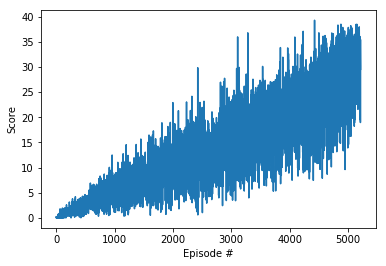

In [6]:
import matplotlib.pyplot as plt

# plot the scores
fig = plt.figure()
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()